In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

# Model of the ant colony
system_name = 'ant_cons'
# Name of the specific run with the current parmeters
run_name = '2p_nac5'

data_dir = 'data/' + system_name + '/' + run_name + '/'

## Environment

### General parameters

In [10]:
env_params = dict()

# Size of the belly of each ant
env_params['max_k'] = 10
# Number of recipient in the colony
env_params['n_recipients'] = 1
# Probability of a succesfull gathering
env_params['p_succ'] = 0.9

if system_name == 'ant_cons':
    # Probability that the food of a recipient decreases
    env_params['p_consume'] = 0.25

### Initial condition

In [11]:
# Number between 1-max_k for a deterministic initialization of the ant food
# Number greater than max_k for a random initialization
env_params['init_k'] = [env_params['max_k']+1 for _ in range(env_params['n_recipients']+1)]

## Algorithm

### Algorithm type

In [12]:
alg_params = dict()
alg_params['alg_type'] = 'nac'
alg_params['gamma'] = 0.999
alg_params['stop_by_discount'] = 'true'

# TIME
alg_params['n_steps'] = 10000000 # Number of training steps
alg_params['traj_points'] = 100

### General parameters

In [13]:
# CRITIC LEARNING RATE
alg_params['a0'] = 0.005
alg_params['ac'] = alg_params['n_steps'] / 300
alg_params['a_expn'] = 0.8
alg_params['a_burn'] = alg_params['n_steps'] / 2

# ACTOR LEARNING RATE
alg_params['b0'] = 0.000005
alg_params['bc'] = alg_params['n_steps'] / 300
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = alg_params['n_steps']

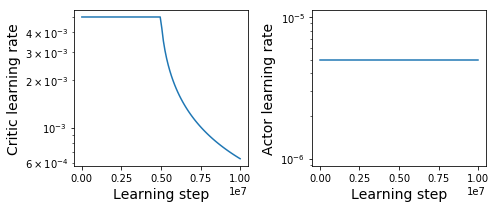

In [14]:
fig, (ax1, ax2) = ut.plot_lr(alg_params)
plt.tight_layout()

### Init condition of the learning

In [15]:
# INITIAL CONDITIONS
# Comment 'init_q_path' for a flat policy
#alg_params['init_q_path'] = '../data/' + system_name + '/sarsa_a/best_quality.txt' 
alg_params['init_values'] = 100
#alg_params['init_values_rand'] = 150

## Wtriting the parameters in data_dir

In [16]:
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")